In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%precision 3

'%.3f'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('bon', 4, 2)

In [4]:
from src.parameters import ANIMALS, SAMPLING_FREQUENCY

In [5]:
from loren_frank_data_processing import (
    get_interpolated_position_dataframe,
    get_LFP_dataframe,
    get_multiunit_indicator_dataframe,
    make_tetrode_dataframe,
    reshape_to_segments)

In [6]:
tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False)
tetrode_info

animal       area  day    depth descrip  \
animal day epoch tetrode_number                                           
bon    4   2     1                 bon        CA3    4  [[149]]     NaN   
                 2                 bon        CA3    4  [[151]]     NaN   
                 3                 bon        CA1    4  [[100]]     NaN   
                 4                 bon        CA1    4  [[107]]     NaN   
                 5                 bon        CA1    4  [[105]]     NaN   
                 6                 bon        NaN    4    [[0]]     NaN   
                 7                 bon        CA3    4  [[162]]     NaN   
                 8                 bon        CA3    4  [[154]]     NaN   
                 9                 bon        NaN    4      NaN     NaN   
                 10                bon        CA3    4  [[146]]     NaN   
                 11                bon        CA1    4   [[96]]     NaN   
                 12                bon        CA1    4  [[136]]     NaN   
                 13                bon        CA1    4   [[94]]     NaN   
                 14                bon        CA1    4   [[96]]     NaN   
                 15                bon        NaN    4    [[0]]     NaN   
                 16                bon        NaN    4      NaN     NaN   
                 17                bon        CA1    4  [[108]]     NaN   
                 18                bon        CA3    4  [[138]]     NaN   
                 19                bon        CA3    4  [[130]]     NaN   
                 20                bon        CA3    4  [[132]]     NaN   
                 21                bon        CA3    4  [[147]]     NaN   
                 22                bon        CA3    4  [[171]]     NaN   
                 23                bon        CA3    4  [[152]]     NaN   
                 24                bon        CA1    4  [[109]]     NaN   
                 25                bon        CA3    4  [[144]]     NaN   
                 26                bon        NaN    4      NaN     NaN   
                 27                bon        CA3    4  [[158]]     NaN   
                 28                bon        CA1    4  [[103]]     NaN   
                 29                bon        CA1    4  [[118]]     NaN   
                 30                bon  Reference    4    [[0]]     NaN   

                                 epoch hemisphere  maxcell  nearCA2  numcells  \
animal day epoch tetrode_number                                                 
bon    4   2     1                   2      right      1.0      0.0      10.0   
                 2                   2      right      NaN      0.0       5.0   
                 3                   2      right      NaN      0.0       0.0   
                 4                   2      right      NaN      0.0       2.0   
                 5                   2      right      NaN      0.0       5.0   
                 6                   2        NaN      NaN      NaN       0.0   
                 7                   2      right      NaN      0.0       2.0   
                 8                   2      right      NaN      0.0       0.0   
                 9                   2        NaN      NaN      NaN       NaN   
                 10                  2      right      NaN      0.0       4.0   
                 11                  2      right      NaN      0.0       6.0   
                 12                  2       left      NaN      0.0       4.0   
                 13                  2       left      NaN      0.0       4.0   
                 14                  2       left      1.0      0.0       8.0   
                 15                  2        NaN      NaN      NaN       0.0   
                 16                  2        NaN      NaN      NaN       NaN   
                 17                  2       left      NaN      0.0       2.0   
                 18                  2       left      NaN      0.0       7.0   
           

In [7]:
from loren_frank_data_processing.position import get_linear_position_structure

mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
hippocampal_tetrodes = tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'CA3']) &
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False) &
    tetrode_info.numcells > 0]

def millisecond_time(epoch_key, animals):
    '''Convert position timestamps to milliseconds to match xinyi'''
    return get_linear_position_structure(epoch_key, animals).resample('1ms').mean().index
            
position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS, max_distance_from_well=10,
                                                    time_function=millisecond_time)

marks = [(get_multiunit_indicator_dataframe(tetrode_key, ANIMALS, time_function=millisecond_time)
          .loc[:, mark_variables])
         for tetrode_key in hippocampal_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
         if (tetrode_marks.loc[(position_info.speed > 4) & position_info.is_correct, :].dropna()
             .shape[0]) != 0]

millisecond_time(epoch_key, ANIMALS)

TimedeltaIndex(['00:41:01.011300', '00:41:01.012300', '00:41:01.013300',
                '00:41:01.014300', '00:41:01.015300', '00:41:01.016300',
                '00:41:01.017300', '00:41:01.018300', '00:41:01.019300',
                '00:41:01.020300',
                ...
                '00:56:44.970300', '00:56:44.971300', '00:56:44.972300',
                '00:56:44.973300', '00:56:44.974300', '00:56:44.975300',
                '00:56:44.976300', '00:56:44.977300', '00:56:44.978300',
                '00:56:44.979300'],
               dtype='timedelta64[ns]', name='time', length=943969, freq='L')

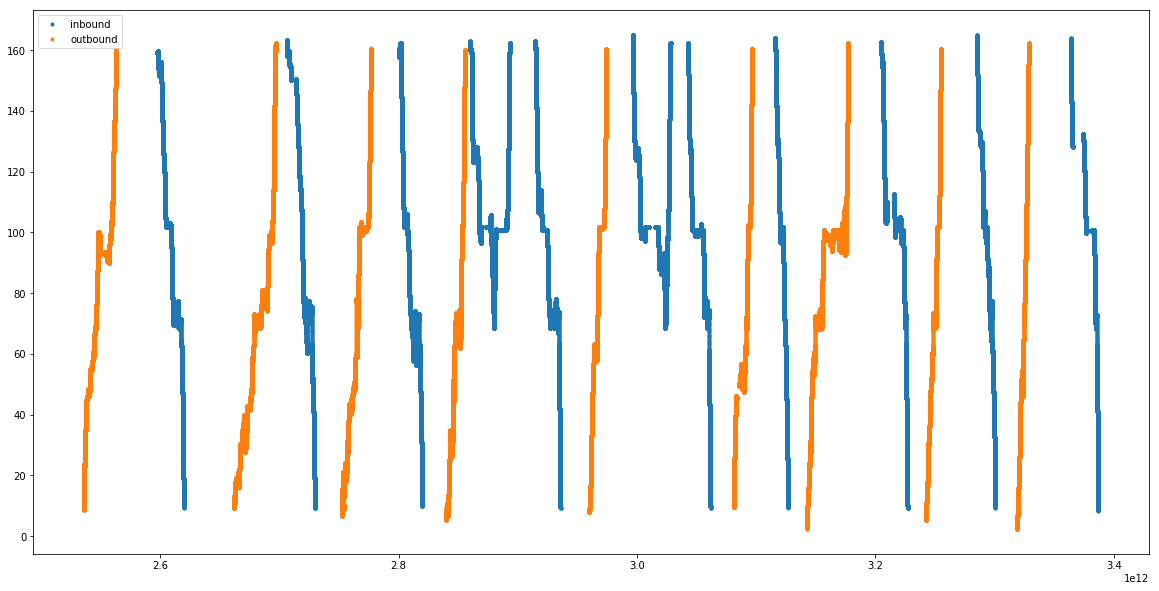

In [8]:
inbound = position_info.linear_distance.loc[
    (position_info.task == 'Inbound') &
    (position_info.speed > 4)
]
outbound = position_info.linear_distance.loc[
    (position_info.task == 'Outbound') &
    (position_info.speed > 4)
]
plt.figure(figsize=(20, 10))
plt.plot(inbound.index.values, inbound.values, linestyle='None', marker='.', label='inbound')
plt.plot(outbound.index.values, outbound.values, linestyle='None', marker='.', label='outbound');
plt.legend();

In [9]:
position = position_info.loc[position_info.speed > 4].linear_distance.values
spike_marks = np.stack([m.loc[position_info.speed > 4] for m in marks], axis=0)
trajectory_direction = position_info.loc[position_info.speed > 4].task.values

/Users/edeno/miniconda3/envs/Categorize_Replay_2017/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



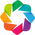

INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


In [10]:
from replay_classification import ClusterlessDecoder

decoder = ClusterlessDecoder(
    position, trajectory_direction, spike_marks,
    replay_speedup_factor=16,
    n_position_bins=30
)
decoder.fit();

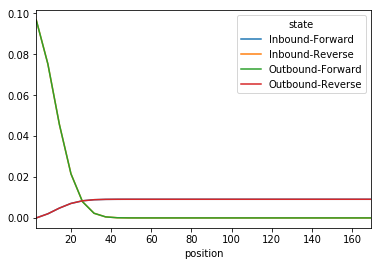

In [11]:
decoder.plot_initial_conditions()

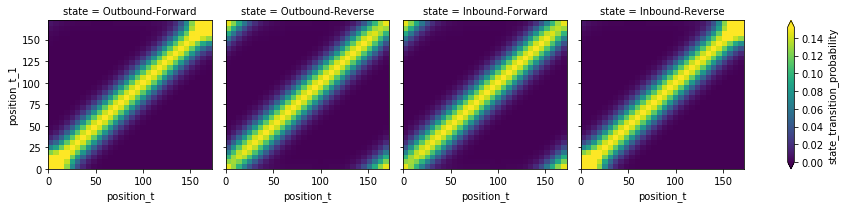

In [12]:
decoder.plot_state_transition_model()

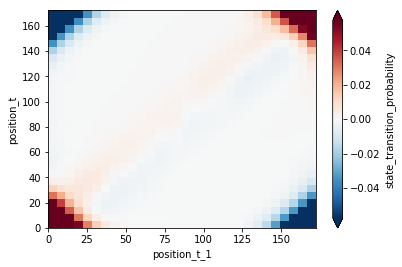

In [13]:
state_transition = decoder.state_transition_matrix

(state_transition.sel(state='Outbound-Forward') - state_transition.sel(state='Inbound-Forward')).plot(
    x='position_t_1', y='position_t', robust=True);

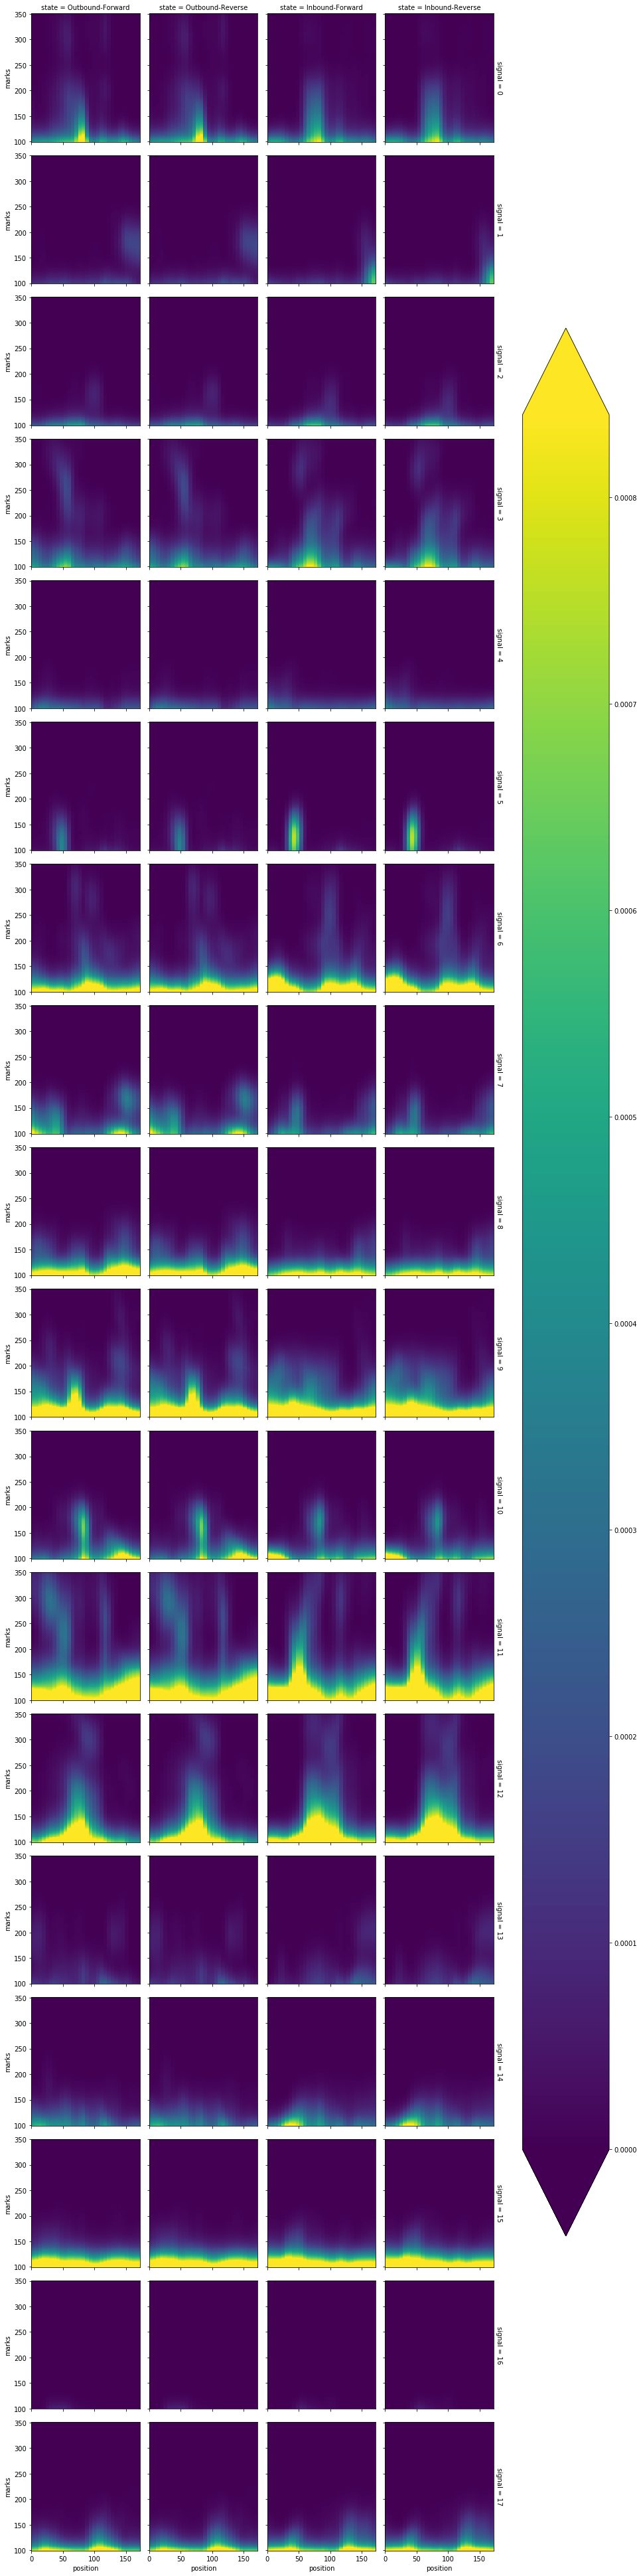

In [14]:
decoder.plot_observation_model();

In [15]:
ripple_times = np.array([[2790.730, 2791.069],
                         [2570.073, 2570.246],
                         [2947.943, 2948.179],
                         [2585.179, 2585.421]])
ripple_times = pd.DataFrame({'start_time': pd.to_timedelta(ripple_times[:, 0], unit='s'),
                             'end_time': pd.to_timedelta(ripple_times[:, 1], unit='s')},
                           index=pd.Index(np.arange(4) + 1, name='ripple_number'))
ripple_times = ripple_times.reindex_axis(['start_time', 'end_time'], axis=1)
ripple_times

,start_time,end_time
ripple_number,,
1,00:46:30.730000,00:46:31.069000
2,00:42:50.073000,00:42:50.246000
3,00:49:07.943000,00:49:08.179000
4,00:43:05.179000,00:43:05.421000


In [16]:
from src.analysis import _get_ripple_marks

test_marks = _get_ripple_marks(marks, ripple_times)

In [17]:
results = [decoder.predict(ripple_marks, time)
           for ripple_marks, time in test_marks]

In [18]:
for r in results:
    r.results['time'] = r.results['time'].to_index().total_seconds()

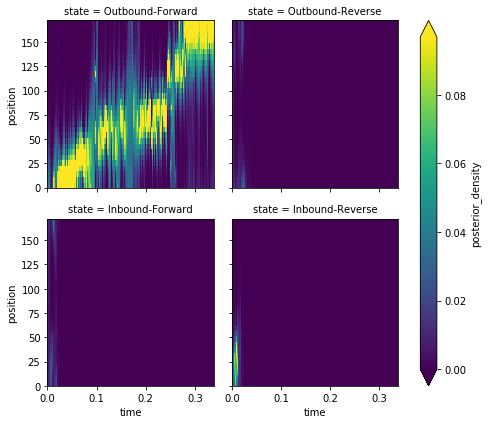

In [19]:
results[0].plot_posterior_density();

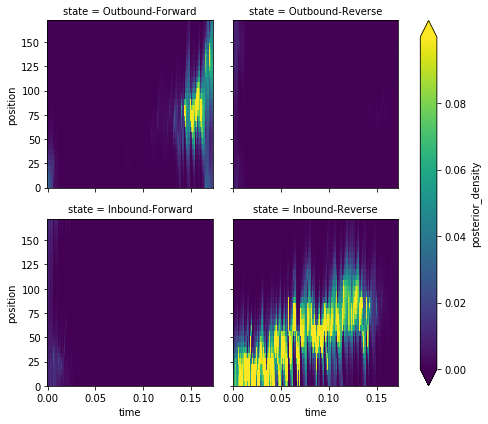

In [20]:
results[1].plot_posterior_density();

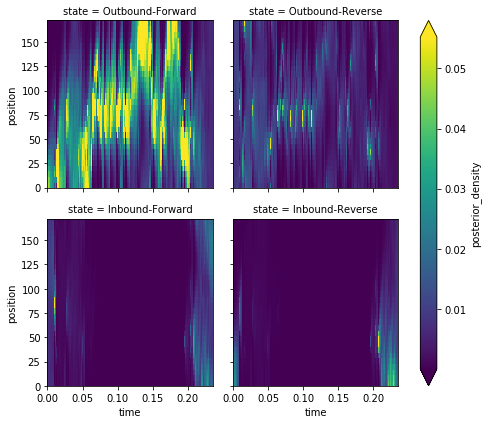

In [21]:
results[2].plot_posterior_density();

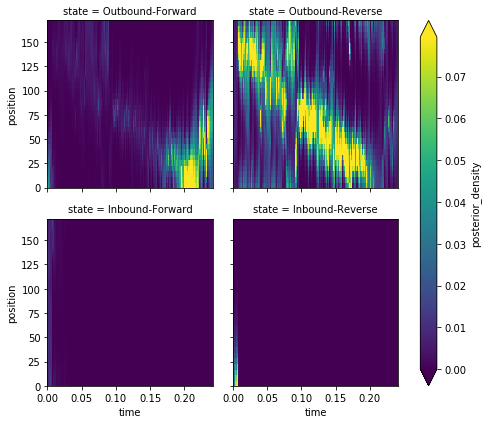

In [22]:
results[3].plot_posterior_density();

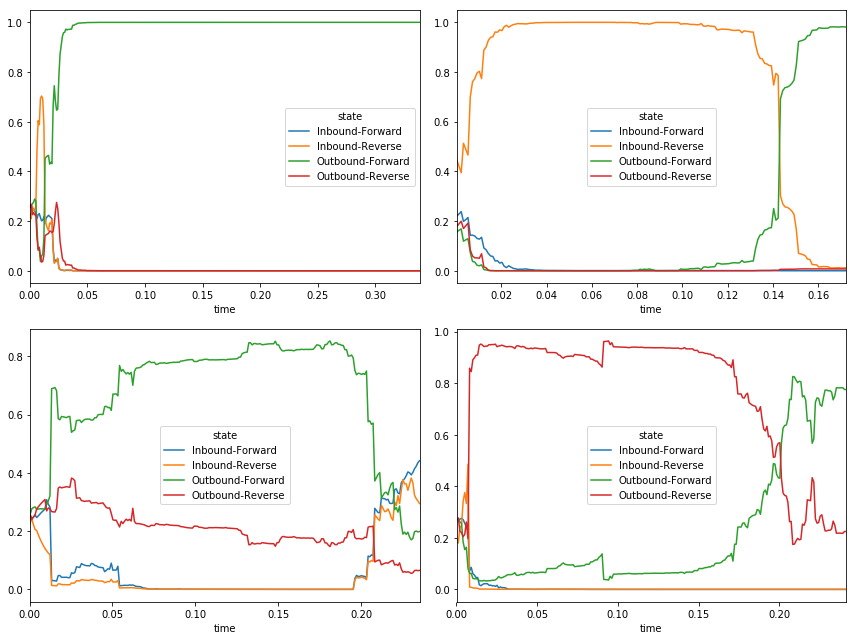

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
for ax, r in zip(axes.ravel().tolist(), results):
    r.plot_state_probability(ax=ax);
plt.tight_layout()

In [29]:
results[2].predicted_state()

'Outbound-Forward'